In [159]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import contextily as ctx

from stats import get_stats

interval_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/interval')
ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/')
outdir = Path('/bsuhome/zacharykeskinen/uavsar-validation/data/interval/')
combo_dir = outdir.joinpath('no_sd')

In [160]:
import requests
import urllib
import pandas as pd
url = r'https://epqs.nationalmap.gov/v1/json?'
def elevation_function(df, lat_column, lon_column):
    """
    Query service using lat, lon. add the elevation values as a new column.
    https://gis.stackexchange.com/questions/338392/getting-elevation-for-multiple-lat-long-coordinates-in-python
    """
    elevations = []
    for lat, lon in zip(df[lat_column], df[lon_column]):
                
        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }
        
        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        #elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
        #new 2023:
        elevations.append(result.json()['value'])

    df['elev_meters'] = elevations

elevation_function(sub, 'Latitude', 'Longitude')

In [161]:
snotel = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/snotel.parq')
snotel = snotel.reset_index(level = 1)

In [225]:
df['snotel_hn'] = np.nan
for i, r in df.iterrows():
    if 'Banner' in r.site:
        group = 'banner'
        snotel_site = 'banner'
    elif 'Bogus' in r.site or 'BB_' in r.site or 'LDP' in r.site:
        group = 'bogus'
        snotel_site = 'bogus'
    elif 'Mores' in r.site or 'MC_' in r.site or 'K-' in r.site or 'TOW-' in r.site:
        group = 'mores'
        snotel_site = 'mores'
    elif 'LR_' in r.site:
        group = 'hwy-21'
        snotel_site = 'banner'
    else:
        continue
    sub_snotel = snotel[snotel.site_name == snotel_site]
    diff = sub_snotel[r.date_t2].mean() - sub_snotel[r.date_t1].mean()
    df.loc[i, 'snotel_hn'] = diff.SD
    df.loc[i, 'group'] = group
    df.loc[i, 'snotel'] = snotel_site

df['snotel_diff'] = df['snotel_hn'] - df['hn']

/tmp/ipykernel_21184/3191464755.py:18: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  diff = sub_snotel[r.date_t2].mean() - sub_snotel[r.date_t1].mean()
/tmp/ipykernel_21184/3191464755.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  diff = sub_snotel[r.date_t2].mean() - sub_snotel[r.date_t1].mean()
/tmp/ipykernel_21184/3191464755.py:18: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  diff = sub_snotel[r.date_t2].mean() - sub

In [174]:
def triangle(x, y):
    return np.sqrt(x*x + y*y)

In [183]:
matches = {}
for snotel_site in snotel.site_name.unique():
    if snotel_site == 'jackson':
        continue
    nearest = None
    dist = 10
    snotel_x = snotel[snotel.site_name == snotel_site].iloc[0].lon
    snotel_y = snotel[snotel.site_name == snotel_site].iloc[0].lat
    for s in combo.site.unique():
        g = combo[combo.site == s].geometry.iloc[0]
        xd = (g.x - snotel_x)
        yd = (g.y - snotel_y)
        dt = triangle(xd, yd)
        if dt < dist:
            nearest = s
            dist = dt
    matches[snotel_site] = nearest

In [ ]:
for snotel_site, board_site in matches.items():
    print(snotel_site)
    y = combo[combo.site == board_site]
    print(y)
    sns.boxplot(y.hn)
    plt.show()

<AxesSubplot:xlabel='hn', ylabel='snotel_hn'>

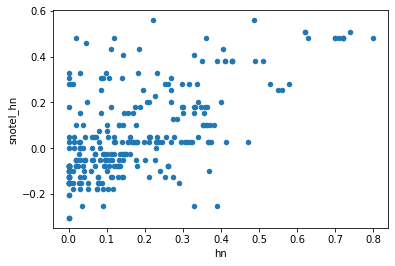

In [191]:
combo[['date_t1', 'date_t2','hn','snotel_hn']].plot.scatter(x = 'hn', y = 'snotel_hn')

In [102]:
combo['snotel_diff'] = combo['snotel_hn'] - combo['hn']

<AxesSubplot:xlabel='snotel_diff', ylabel='site'>

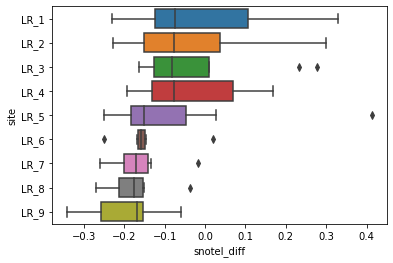

In [189]:
sns.boxplot(data = combo[combo.group == 'hwy-21'], x = 'snotel_diff', y = 'site')

In [2]:
pitdir= Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits')
pits = []
for env_fp in pitdir.glob('*/*Summary_Environment*.csv'):
    df = pd.read_csv(env_fp)
    pits.append(df)
pits = pd.concat(pits, ignore_index=True)
pits['PitID'] = pits.PitID.apply(lambda x: '_'.join(x.split('_')[:2]))
pits['PitID_abv'] = pits.PitID.apply(lambda x: '_'.join(x.split('_')[:1]))
pits['state'] = pits.PitID.apply(lambda x: ''.join(x.split('_')[0][:2]))
pits = pits[pits.state == 'ID']

In [211]:
df = pd.read_csv('/bsuhome/zacharykeskinen/uavsar-validation/data/interval/interval_sd_v5.csv')
# add environment variables
# df['ground_wet'] = df.apply(lambda r: pits.loc[pits.PitID == f"{r.PitID}_{r.date_t2.strftime('%Y%m%d')}"]['Ground Condition'], axis = 1).bfill(axis = 1).iloc[:, 0]
# df['ground_roughness'] = df.apply(lambda r: pits.loc[pits.PitID == f"{r.PitID}_{r.date_t2.strftime('%Y%m%d')}"]['Ground Roughness'], axis = 1).bfill(axis = 1).iloc[:, 0]
# df['ground_veg'] = df.apply(lambda r: pits.loc[pits.PitID == f"{r.PitID}_{r.date_t2.strftime('%Y%m%d')}"]['Ground Vegetation'], axis = 1).bfill(axis = 1).iloc[:, 0]
# df['ground_height'] = df.apply(lambda r: pits.loc[pits.PitID == f"{r.PitID}_{r.date_t2.strftime('%Y%m%d')}"]['Height of Ground Vegetation (cm)'], axis = 1).bfill(axis = 1).iloc[:, 0]
# df['canopy'] = df.apply(lambda r: pits.loc[pits.PitID == f"{r.PitID}_{r.date_t2.strftime('%Y%m%d')}"]['Canopy'], axis = 1).bfill(axis = 1).iloc[:, 0]

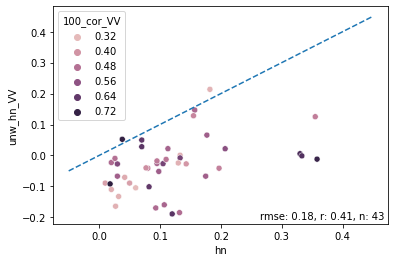

: 

In [257]:
y = 'hn' #swe
for x in ['unw_hn_VV']:
    fig, ax = plt.subplots()
    # x = 'nearest_int_sd_delta_VV'
    sub = df[~df['comments'].str.contains('wind')].copy()
    sub = sub[~sub['comments'].str.contains('melt')]
    sub = sub[sub.swe > 0]
    sub = sub[sub.snotel_diff.abs() < 0.25]
    # sub = sub[sub.week != 6]
    # sub = df.copy()
    sns.scatterplot(data = sub, x = y, y = x, ax = ax, hue = '100_cor_VV')
    ax.plot([-0.05,0.45], [-0.05,0.45], linestyle = 'dashed')
    rmse, r, n = get_stats(sub[y], sub[x])
    ax.text(.99, .01, s = f'rmse: {rmse:.2f}, r: {r:.2}, n: {n}', ha = 'right', va = 'bottom', transform = ax.transAxes)
#     ax.set_xlim(0, 0.75)
#     ax.set_ylim(-0.75, 0.75)
    plt.show()

In [247]:
sub.snotel_diff.abs() > 0.15

0      False
1      False
2      False
3      False
5      False
       ...  
117    False
118     True
119     True
122    False
124     True
Name: snotel_diff, Length: 79, dtype: bool

In [239]:
df[df.week == 3]

,Unnamed: 0,date_t2,swe,hn,time_t2,obs_year,swe_a,hn_a,swe_b,hn_b,...,100_cor_HV,100_unw_hn_HV,int_hn_HH,unw_hn_HH,100_cor_HH,100_unw_hn_HH,snotel_hn,group,snotel,snotel_diff
20,200,2021-01-26,0.009,0.026,12:05,2020-2021,7.62,2.5,10.16,2.8,...,0.436191,-0.021300,0.011508,-0.000947,0.462907,-0.023525,0.0254,bogus,bogus,-0.0006
24,211,2021-01-29,0.024,0.207,14:40,2020-2021,25.00,21.0,21.0,19.0,...,0.479775,-0.006108,0.044089,-0.001805,0.512327,-0.002089,0.2032,bogus,bogus,-0.0038
27,223,2021-01-27,0.008,0.082,14:00,2020-2021,8.00,8.0,8.5,8.5,...,0.300398,-0.011628,-0.027574,NaN,0.313307,-0.008032,0.0000,bogus,bogus,-0.0820
42,254,2021-01-27,0.017,0.177,8:50,2020-2021,16.00,18.0,17.0,18.0,...,0.446157,0.048958,0.092781,0.089876,0.496229,0.055493,-0.0508,hwy-21,banner,-0.2278
49,264,2021-01-27,0.011,0.113,9:00,2020-2021,11.00,11.0,11.0,11.0,...,0.492803,0.019903,0.032256,0.020282,0.503516,0.027454,-0.0508,hwy-21,banner,-0.1638
55,273,2021-01-27,0.016,0.143,9:30,2020-2021,16.00,14.5,15.0,14.5,...,0.311973,0.010100,-0.088509,-0.056080,0.319879,0.016676,-0.0508,hwy-21,banner,-0.1938
62,284,2021-01-28,0.024,0.330,10:00,2020-2021,24.00,33.0,24.0,33.0,...,0.649194,0.002667,0.000473,0.014977,0.673173,0.008130,0.1778,hwy-21,banner,-0.1522
78,310,2021-01-28,0.023,0.358,14:30,2020-2021,24.00,35.5,23.0,36.0,...,0.669874,-0.028173,-0.026422,-0.013212,0.672722,-0.024586,0.1778,hwy-21,banner,-0.1802
84,319,2021-01-28,0.024,0.333,16:00,2020-2021,24.00,33.0,24.0,33.0,...,0.597047,-0.024886,0.004412,-0.002660,0.566993,-0.024809,0.1778,hwy-21,banner,-0.1552


<AxesSubplot:xlabel='Week No.', ylabel='sd_diff'>

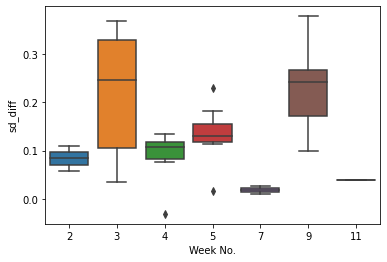

In [25]:
sns.boxplot(data = df, y = 'sd_diff', x = 'Week No.')

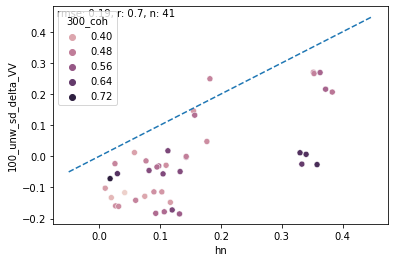

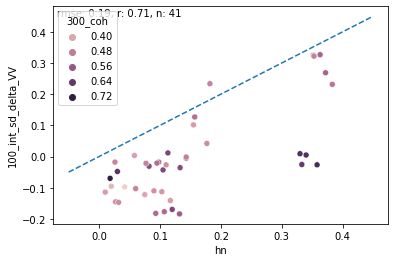

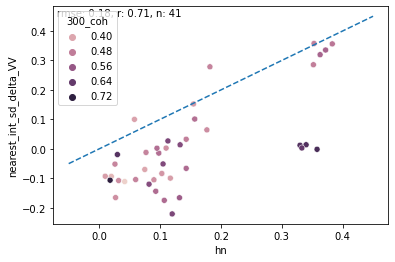

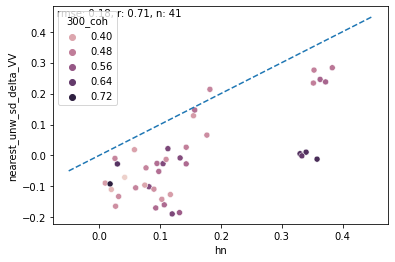

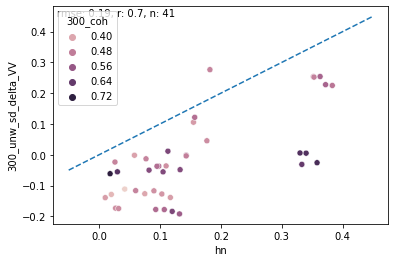

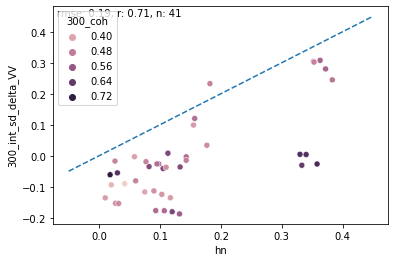

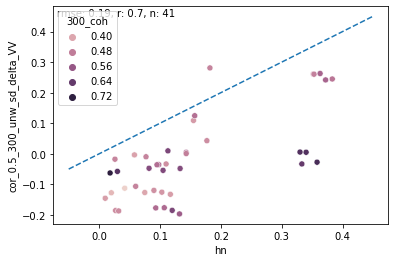

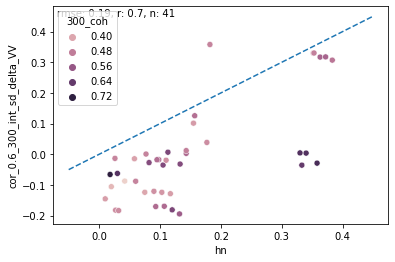

In [16]:
y = 'hn' # hn
for x in ['100_unw_sd_delta_VV', '100_int_sd_delta_VV', 'nearest_int_sd_delta_VV', 'nearest_unw_sd_delta_VV',
          '300_unw_sd_delta_VV', '300_int_sd_delta_VV', 'cor_0.5_300_unw_sd_delta_VV', 'cor_0.6_300_int_sd_delta_VV']:
    fig, ax = plt.subplots()
    sub = df[~df['Comments'].str.contains('wind')].copy()
    sub = sub[~sub['Comments'].str.contains('melt')].copy()
    # sub = df.copy()
    sub.loc[:, x] = sub.loc[:, x] # * (997/250)
    sns.scatterplot(data = sub, x = y, y = x, ax = ax, hue = '300_coh')
    ax.plot([-0.05,0.45], [-0.05,0.45], linestyle = 'dashed')
    rmse, r, n = get_stats(sub[y], sub[x])
    ax.text(.01, .99, s = f'rmse: {rmse:.2f}, r: {r:.2}, n: {n}', ha = 'left', va = 'top', transform = ax.transAxes)
#     ax.set_xlim(0, 0.75)
#     ax.set_ylim(-0.75, 0.75)
    plt.show()

<AxesSubplot:xlabel='hn', ylabel='nearest_unw_sd_delta_VV'>

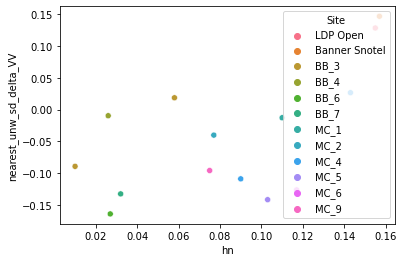

In [107]:
sub = df[~df['Comments'].str.contains('wind')].copy()
sub = sub[~sub['Comments'].str.contains('melt')].copy()
# sub = df.copy()
sub.loc[:, x] = sub.loc[:, x] # * (997/250)
sub = sub[~sub.Site.str.contains('LR')]
sns.scatterplot(data = sub, x = 'hn', y = 'nearest_unw_sd_delta_VV', hue = 'Site')

<AxesSubplot:xlabel='sd_diff', ylabel='Melt'>

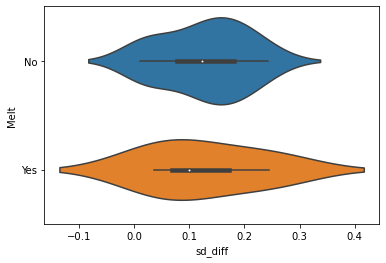

In [108]:
sns.violinplot(data = sub, x= 'sd_diff', y = 'Melt')

In [193]:
import requests
import urllib
import pandas as pd
url = r'https://epqs.nationalmap.gov/v1/json?'
def elevation_function(df, lat_column, lon_column):
    """
    Query service using lat, lon. add the elevation values as a new column.
    https://gis.stackexchange.com/questions/338392/getting-elevation-for-multiple-lat-long-coordinates-in-python
    """
    elevations = []
    for lat, lon in zip(df[lat_column], df[lon_column]):
                
        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }
        
        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        #elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
        #new 2023:
        elevations.append(result.json()['value'])

    df['elev_meters'] = elevations

elevation_function(sub, 'Latitude', 'Longitude')

KeyError: 'Latitude'

In [194]:
combo['lat'] = combo.geometry.y
combo['lon'] = combo.geometry.x

In [195]:
elevation_function(combo, 'lat', 'lon')

In [199]:
combo['elev_meters'] = combo.elev_meters.astype(float)

<AxesSubplot:ylabel='snotel_diff'>

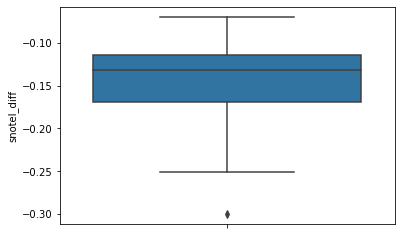

In [200]:
sns.boxplot(data = combo[combo.site == 'Banner Snotel'], y = 'snotel_diff')

In [206]:
combo['days'] = combo['days_between'].dt.days

Text(0, 0.5, 'snotel - board')

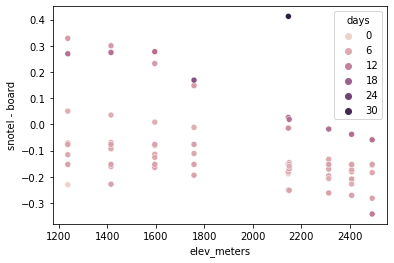

In [210]:
fig, ax = plt.subplots()
sns.scatterplot(data = combo[combo.group == 'hwy-21'], y = 'snotel_diff', hue = 'days', x = 'elev_meters', ax = ax)
# sns.scatterplot(data = combo[combo.group == 'banner'], y = 'snotel_diff', hue = 'days', x = 'elev_meters', ax = ax)
plt.ylabel('snotel - board')
# plt.xlim(1200, 2600)
# plt.ylim(-0.4, 0.4)

<AxesSubplot:xlabel='elev_meters', ylabel='sd_diff'>

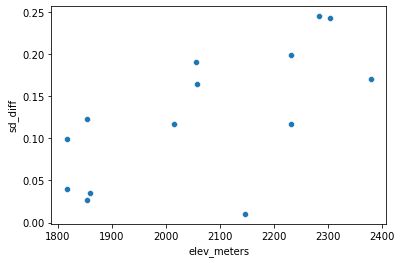

In [139]:
sns.scatterplot(data = sub, y = 'sd_diff', x = 'elev_meters')

<AxesSubplot:xlabel='den', ylabel='sd_diff'>

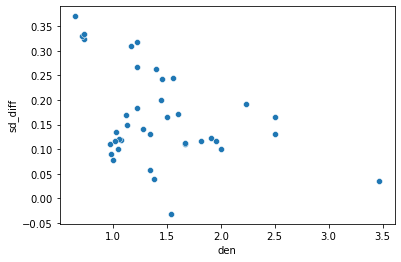

In [112]:
sns.scatterplot(data = sub, y = 'sd_diff', x = 'den')

<AxesSubplot:xlabel='date_t2', ylabel='sd_diff'>

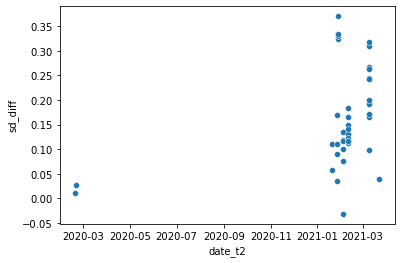

In [113]:
sns.scatterplot(data = sub, y = 'sd_diff', x = 'date_t2')

<AxesSubplot:xlabel='month', ylabel='sd_diff'>

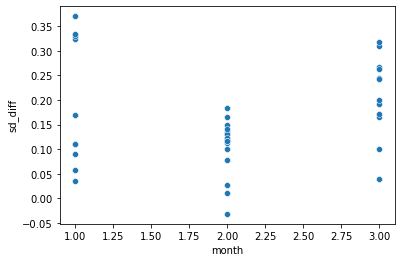

In [114]:
sns.scatterplot(data = sub, y = 'sd_diff', x = 'month')

<AxesSubplot:xlabel='Latitude', ylabel='sd_diff'>

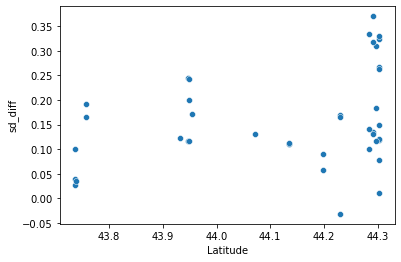

In [115]:
sns.scatterplot(data = sub, y = 'sd_diff', x = 'Latitude')

<AxesSubplot:xlabel='Longitude', ylabel='sd_diff'>

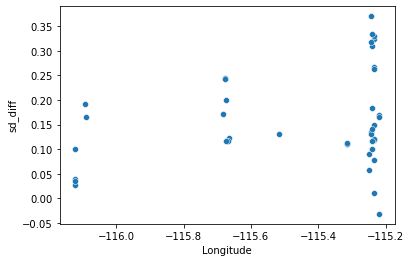

In [116]:
sns.scatterplot(data = sub, y = 'sd_diff', x = 'Longitude')